In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [3]:
cuml_umap = cumlUMAP()

In [4]:
import numpy as np
import pandas as pd
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms#

In [6]:
from avgn.visualization.projections import scatter_spec, scatter_projections
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [7]:
import hdbscan

## load data

In [8]:
DATASET_ID = 'swamp_sparrow'

In [9]:
syllable_df = pd.read_pickle(DATA_DIR / 'syllable_dfs' / DATASET_ID / 'swampsparrow-taper_with_freq2.pickle')

In [10]:
syllable_df[:3]

start_time  end_time  syllable  pos_in_syllable  peakfreq_start  \
0      0.1705    0.2145       0.0              0.0     6158.496094   
1      0.2035    0.2550       0.0              1.0     3746.777344   
2      0.2625    0.2910       0.0              2.0     8311.816406   

   peakfreq_end       indv  indvi              POPID      GRIDX        GRIDY  \
0   5254.101562  NYHVTIV18      0  Hudson Valley, NY  42.042489  -73.9237463   
1   4048.242188  NYHVTIV18      0  Hudson Valley, NY  42.042489  -73.9237463   
2   3875.976562  NYHVTIV18      0  Hudson Valley, NY  42.042489  -73.9237463   

             key                                              audio   rate  \
0  SWSP09TIV18L1  [0.0, 0.0005278791589983579, 0.001123593156707...  44100   
1  SWSP09TIV18L1  [0.0, -0.015641441632961404, -0.04495665944855...  44100   
2  SWSP09TIV18L1  [-0.0, -0.001130732482877271, -0.0025247620611...  44100   

   syll_len      f_start        f_end  \
0  0.043991  5857.031250  6287.695312   
1  0.051497  5469.433594  4220.507812   
2  0.028503  7795.019531  3919.042969   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [11]:
len(syllable_df.indv.unique())

615

In [12]:
### get population info

In [13]:
pd.DataFrame({
    i: [np.sum(syllable_df['POPID'].values == i)]
    for i in np.unique(syllable_df['POPID'].values)
}).T.sort_values(
    by=0, ascending=False)

0
Conneaut, PA       31938
Hudson Valley, NY  15527
Horicon, WI        14825
Adirondacks, NY    13007
Waterloo, MI       12110
Montezuma, NY      10091

# Get data/ embeddings

In [14]:
specs = np.stack(syllable_df['spectrogram'].values)
#embedding = np.vstack(syllable_df['umap_0.5'].values)

In [15]:
syllable_df['f_diff_est'] = syllable_df['f_start'].values - syllable_df['f_end'].values

In [16]:
syllable_df['f_diff'] = syllable_df['peakfreq_start'].values - syllable_df['peakfreq_end'].values

In [17]:
syllable_df['syll_len'] = syllable_df['syll_len']*1000

In [18]:
syllable_df['syll_len'][:5]

0    43.990930
1    51.496599
2    28.503401
3    49.501134
4    55.510204
Name: syll_len, dtype: float64

In [19]:
embedding_freq = np.vstack([
    syllable_df['peakfreq_start'].values,
    syllable_df['peakfreq_end'].values,
]).T

In [20]:
# adding noise over quantization
embedding = np.vstack([
    syllable_df['syll_len']+ np.random.rand(len(syllable_df['syll_len'])),
    syllable_df['f_diff'].values + np.random.rand(len(syllable_df['f_diff']))*100,
]).T
embedding[:,0] = np.log(embedding[:,0])

(-5000, 10000)

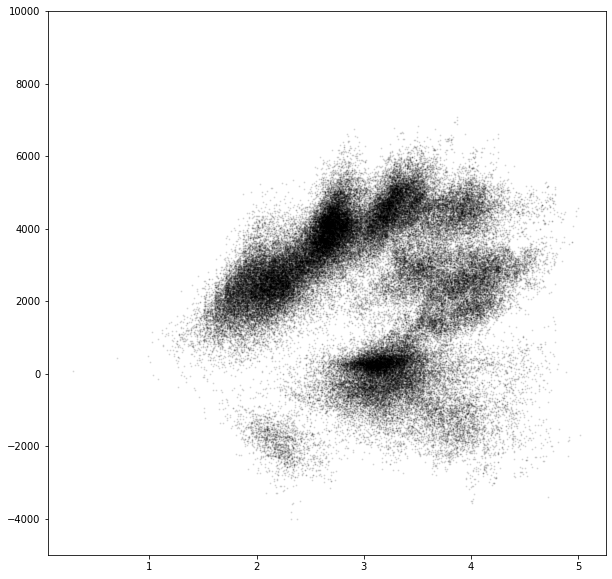

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0],embedding[:,1],  alpha = 0.1, s=1, color='k', rasterized=True)
#ax.set_xlim([1, 1000])
ax.set_ylim([-5000, 10000])
#ax.set_xscale('log')

[[0.12156863 0.46666667 0.70588235]
 [1.         0.73333333 0.47058824]
 [1.         0.59607843 0.58823529]
 [0.76862745 0.61176471 0.58039216]
 [0.78039216 0.78039216 0.78039216]
 [0.61960784 0.85490196 0.89803922]]


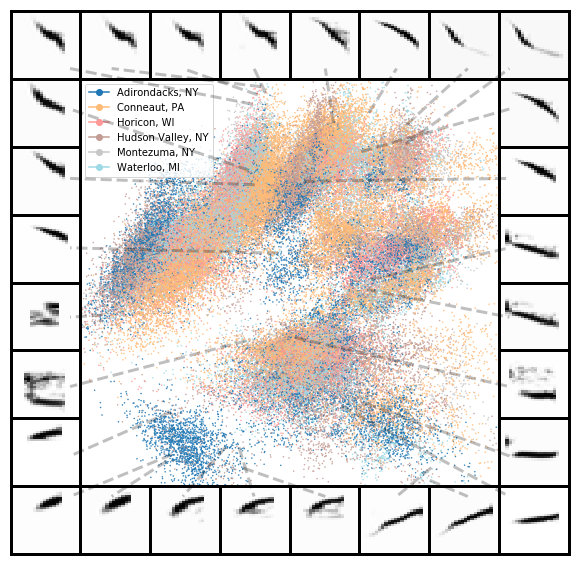

In [22]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df.POPID.values[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

### UMAP for a single community

In [23]:
POPID = 'Conneaut, PA'

In [24]:
subset_df = syllable_df[syllable_df.POPID == POPID]

In [25]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(31938, 704)

In [26]:
#cuml_umap = cumlUMAP()
#umap_embedding = cuml_umap.fit_transform(specs_flattened)

In [27]:
import umap
umap_embedding = umap.UMAP().fit_transform(specs_flattened)

In [28]:
pos = subset_df['pos_in_syllable'].values[:nex]
pos[pos>7 ]= 8

In [29]:
np.sum(pos == 4), np.sum(pos == 4)

(120, 120)

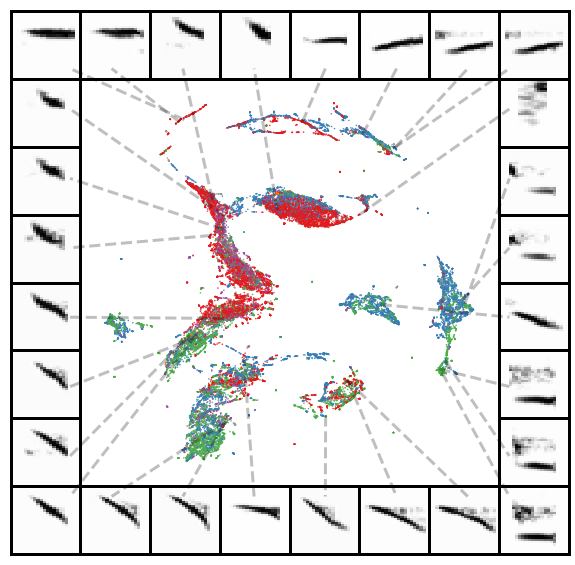

In [30]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);

### Get embedding for single community

In [31]:
# adding noise over quantization

embedding = np.vstack([
    np.log(subset_df['syll_len'] + np.random.rand(len(subset_df['syll_len']))),
    subset_df['f_diff'].values + np.random.rand(len(subset_df['f_diff'])) * 100,
]).T

In [32]:
embedding_freq = np.vstack([
    subset_df['peakfreq_start'].values+ np.random.rand(len(subset_df['peakfreq_start']))*100,
    subset_df['peakfreq_end'].values+ np.random.rand(len(subset_df['peakfreq_end']))*100,
]).T

In [33]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(len(umap_embedding) * 0.01), # the smallest size we would expect a cluster to be
    min_samples=1, # larger values = more conservative clustering
)
clusterer.fit(umap_embedding);
#clusterer.labels_

In [34]:
subset_df['UMAP'] = list(umap_embedding)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
subset_df['HDBSCAN'] = list(clusterer.labels_)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

[[0.12156863 0.46666667 0.70588235]
 [0.68235294 0.78039216 0.90980392]
 [1.         0.49803922 0.05490196]
 [0.17254902 0.62745098 0.17254902]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.58039216 0.40392157 0.74117647]
 [0.54901961 0.3372549  0.29411765]
 [0.76862745 0.61176471 0.58039216]
 [0.96862745 0.71372549 0.82352941]
 [0.49803922 0.49803922 0.49803922]
 [0.7372549  0.74117647 0.13333333]
 [0.85882353 0.85882353 0.55294118]
 [0.61960784 0.85490196 0.89803922]]


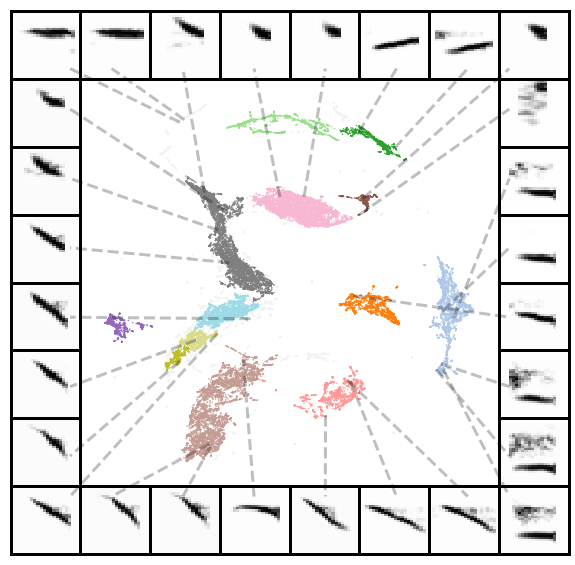

In [37]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);

# cluster in feature space

In [38]:
np.shape(embedding_freq), np.shape(embedding)

((31938, 2), (31938, 2))

In [39]:
#freq_time_features = np.hstack([embedding, embedding_freq])

In [40]:
import scipy.stats

In [41]:
freq_time_features = np.vstack(
    [
        scipy.stats.zscore(np.log(subset_df['syll_len'] + np.random.rand(len(subset_df['syll_len'])))),
        scipy.stats.zscore(subset_df['peakfreq_start'].values+ np.random.rand(len(subset_df['peakfreq_start']))),
        scipy.stats.zscore(subset_df['peakfreq_end'].values+ np.random.rand(len(subset_df['peakfreq_end'])))
    ]
).T


#### GMM

In [42]:
from sklearn.mixture import GaussianMixture

In [43]:
n_classes = 10
mixture_model = GaussianMixture(n_components=n_classes,
              covariance_type="full", max_iter=20, random_state=0)
mixture_model.fit(freq_time_features)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=20,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [44]:
mixture_labels = mixture_model.predict(freq_time_features)

# compare clustering

In [83]:
import sklearn.metrics

##### similarity between labelling

In [84]:
homogenaity, completeness, v_measure_labels = sklearn.metrics.homogeneity_completeness_v_measure(
    list(clusterer.labels_), list(mixture_labels)
)

In [85]:
homogenaity, completeness, v_measure_labels

(0.6327974640524553, 0.7159980849271078, 0.6718316541763045)

##### bootstrapped similarity vs chance

In [86]:
homogenaity, completeness, v_measure_chance = sklearn.metrics.homogeneity_completeness_v_measure(
    list(clusterer.labels_), np.random.permutation(list(mixture_labels))
)
homogenaity, completeness, v_measure_chance

(0.0007472084908229543, 0.0008454519476806267, 0.0007933001393358185)

In [87]:
v_measure_label_chance = [sklearn.metrics.v_measure_score(
    list(clusterer.labels_), np.random.permutation(list(mixture_labels))
) for i in tqdm(range(10000))]
np.sum(np.array(v_measure_labels) > v_measure_label_chance)

10000

In [96]:
np.mean(v_measure_label_chance)

0.0008224016438606427

In [89]:
np.sum(np.array(v_measure_labels) < v_measure_label_chance)

0

In [90]:
np.sum(np.array(v_measure_labels) < v_measure_label_chance) / len(v_measure_label_chance)

0.0

##### similarity of HDBSCAN vs position

In [91]:
homogenaity, completeness, v_measure_hdbscan_pos = sklearn.metrics.homogeneity_completeness_v_measure(
    list(clusterer.labels_[:-1]), list(pos)
)
homogenaity, completeness, v_measure_hdbscan_pos

(0.11459914127614748, 0.19338787501600893, 0.14391570577787352)

In [92]:
v_measure_hdbscan_pos_chance = [sklearn.metrics.v_measure_score(
    list(clusterer.labels_), np.random.permutation(list(mixture_labels))
) for i in tqdm(range(10000))]

In [93]:
np.sum(np.array(v_measure_hdbscan_pos) < v_measure_hdbscan_pos_chance) / len(v_measure_hdbscan_pos_chance)

0.0

##### similarity of mixture labels vs position 

In [94]:
homogenaity, completeness, v_measure_mixture = sklearn.metrics.homogeneity_completeness_v_measure(
    list(mixture_labels[:-1]), list(pos)
)
homogenaity, completeness, v_measure_mixture

(0.13556591299665482, 0.20218589574050327, 0.16230566257270973)

In [95]:
np.sum(np.array(v_measure_mixture) < v_measure_hdbscan_pos_chance) / len(v_measure_hdbscan_pos_chance)

0.0

### UMAP of freq_time_features

In [51]:
#cuml_umap = cumlUMAP()
#umap_embedding_features = cuml_umap.fit_transform(freq_time_features)
umap_embedding_features = umap.UMAP().fit_transform(freq_time_features)

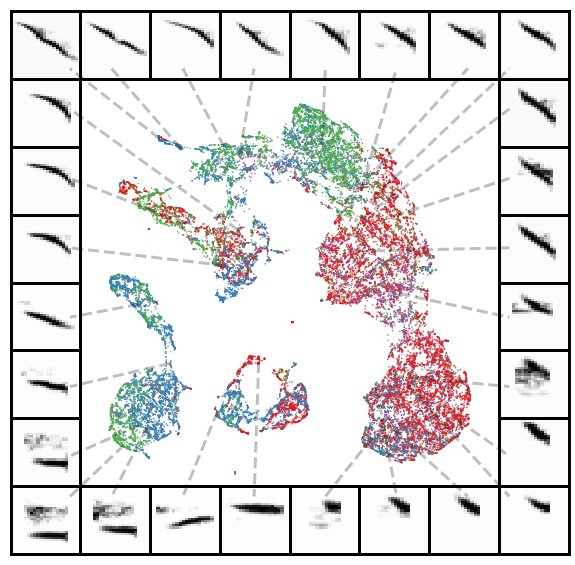

In [52]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding_features[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);

### Save for paper

In [99]:
subset_df[:3]

start_time  end_time  syllable  pos_in_syllable  peakfreq_start  \
0      0.1470    0.1540       0.0              0.0     6244.628906   
1      0.1485    0.1710       0.0              1.0     3273.046875   
2      0.1825    0.2095       0.0              2.0     7924.218750   

   peakfreq_end           indv  indvi         POPID      GRIDX  ...  \
0   4866.503906  PAGeneva08-57      0  Conneaut, PA  41.587287  ...   
1   3057.714844  PAGeneva08-57      0  Conneaut, PA  41.587287  ...   
2   3359.179688  PAGeneva08-57      0  Conneaut, PA  41.587287  ...   

                                               audio   rate   syll_len  \
0  [-0.0, -0.0041904511122867975, -0.004001130574...  44100   7.006803   
1  [0.0, 0.0009144610115166368, 0.003067977726459...  44100  22.517007   
2  [-0.0, -0.0002621038784754687, -0.000141924985...  44100  26.984127   

       f_start        f_end  \
0  2971.582031  3488.378906   
1  4909.570312  3014.648438   
2  7838.085938  3832.910156   

                                         spectrogram   f_diff_est  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  -516.796875   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1894.921875   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  4005.175781   

        f_diff                      UMAP  HDBSCAN  
0  1378.125000    [1.327933, 10.0425205]        8  
1   215.332031    [13.666051, 0.8677807]        0  
2  4565.039062  [-1.8427858, -7.9060984]        7  

[3 rows x 22 columns]

In [102]:
subset_df['UMAP_feat'] = list(umap_embedding_features)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
ensure_dir(DATA_DIR / "paper_data" / "swamp_sparrow" )
subset_df.to_pickle(DATA_DIR / "paper_data" / "swamp_sparrow" / "swamp_sparrow_projections_PA.pickle")

In [98]:
pd.__version__

'0.25.3'

# Plot

In [53]:
save_loc = FIGURE_DIR / 'syllable_dfs' / 'swamp_sparrow_community_wvmeasure' 
ensure_dir(save_loc)
subset_df.to_pickle((save_loc/ POPID.replace(', ', '_')).as_posix())

In [54]:
from avgn.utils.paths import FIGURE_DIR, ensure_dir
FIGURE_DIR  = FIGURE_DIR / 'swampsparrow2'

In [55]:
save_figs = True

#### Plot GMM labels

In [56]:
len(embedding)

31938

In [57]:
len(mixture_labels)

31938

[4.588964113248439, 130.5992624908879, -2003.7140889352215, 6434.747424612408]
[4.588964113248439, 130.5992624908879, -2003.7140889352215, 6434.747424612408]


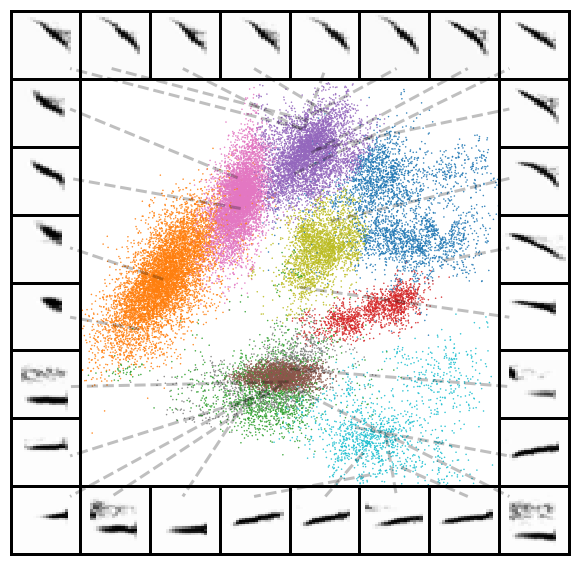

In [58]:
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    embedding,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': mixture_labels,
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'tab10',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
print([np.exp(xmin), np.exp(xmax), ymin, ymax])

if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'len_fchange_GMM_cluster', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([np.exp(xmin), np.exp(xmax), ymin, ymax])

[2225.1090552164155, 9623.230000317448, 2323.484628686787, 6349.476034054837]


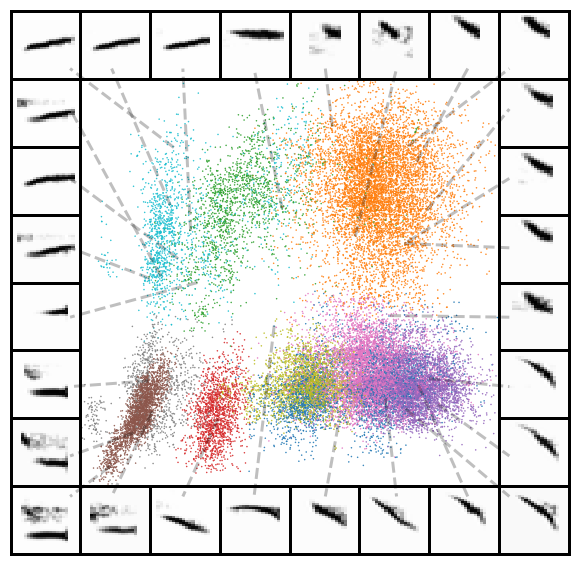

In [59]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    embedding_freq[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': mixture_labels[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'tab10',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);

if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'fstart_fend_GMM_cluster', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[-12.042465019226075, 17.690114860534667, -12.969955444335938, 19.087470054626465]


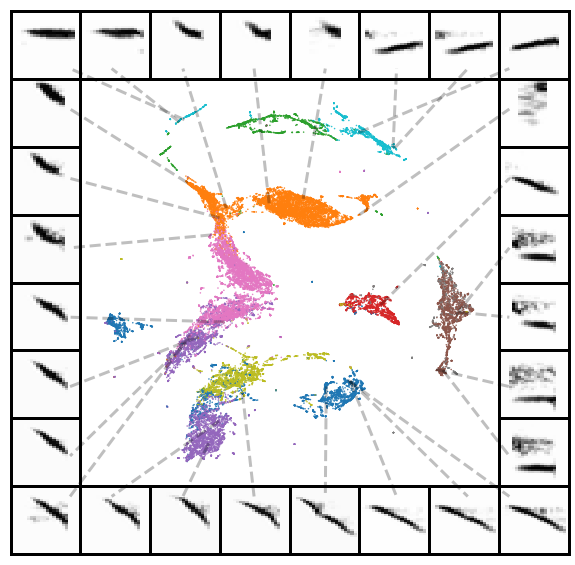

In [60]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': mixture_labels[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'tab10'
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap_GMM_cluster', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[0.0003269769932379942, 84295621.22820505, -7.32641191482544, 20.302898950576783]


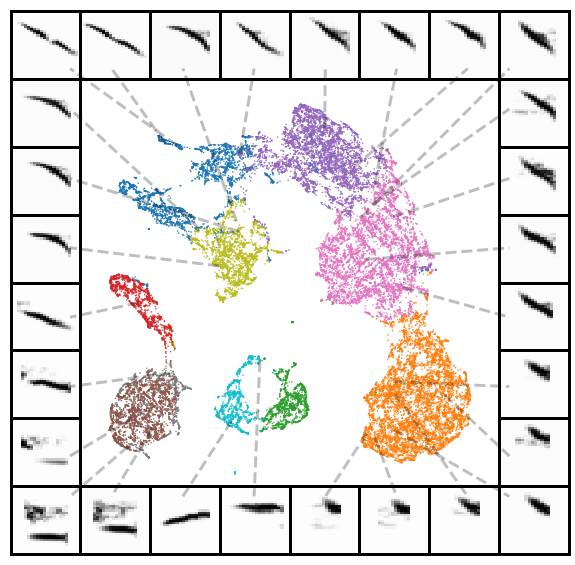

In [61]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding_features[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': mixture_labels[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'tab10',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap-feats_GMM_cluster', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([np.exp(xmin), np.exp(xmax), ymin, ymax])

#### Plot HDBSCAN labels

[[0.12156863 0.46666667 0.70588235]
 [0.68235294 0.78039216 0.90980392]
 [1.         0.49803922 0.05490196]
 [0.17254902 0.62745098 0.17254902]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.58039216 0.40392157 0.74117647]
 [0.54901961 0.3372549  0.29411765]
 [0.76862745 0.61176471 0.58039216]
 [0.96862745 0.71372549 0.82352941]
 [0.49803922 0.49803922 0.49803922]
 [0.7372549  0.74117647 0.13333333]
 [0.85882353 0.85882353 0.55294118]
 [0.61960784 0.85490196 0.89803922]]
[1.523654315213986, 4.872133569742832, -2003.7140889352215, 6434.747424612408]


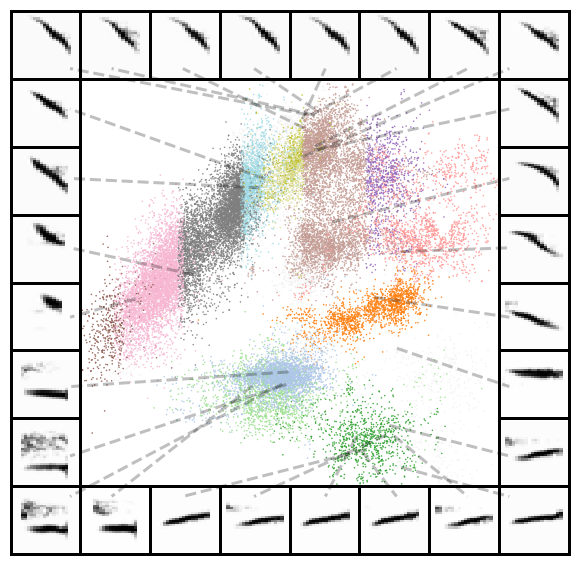

In [62]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:

    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'len_fchange_cluster', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[[0.12156863 0.46666667 0.70588235]
 [0.68235294 0.78039216 0.90980392]
 [1.         0.49803922 0.05490196]
 [0.17254902 0.62745098 0.17254902]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.58039216 0.40392157 0.74117647]
 [0.54901961 0.3372549  0.29411765]
 [0.76862745 0.61176471 0.58039216]
 [0.96862745 0.71372549 0.82352941]
 [0.49803922 0.49803922 0.49803922]
 [0.7372549  0.74117647 0.13333333]
 [0.85882353 0.85882353 0.55294118]
 [0.61960784 0.85490196 0.89803922]]
[2225.1090552164155, 9623.230000317448, 2323.484628686787, 6349.476034054837]


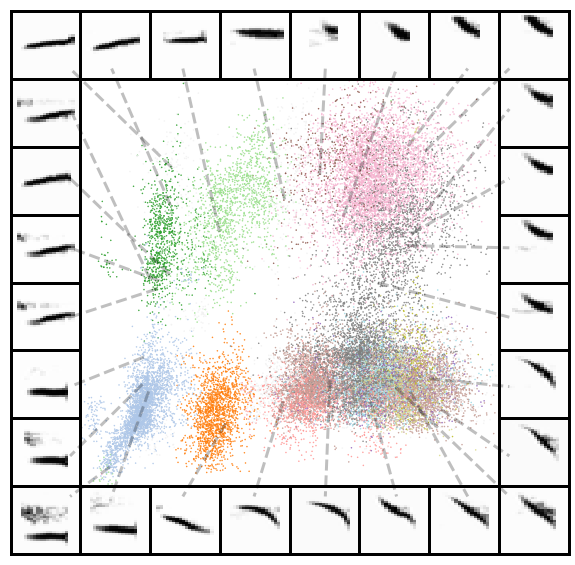

In [63]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    embedding_freq[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:

    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'fstart_fend_cluster', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[[0.12156863 0.46666667 0.70588235]
 [0.68235294 0.78039216 0.90980392]
 [1.         0.49803922 0.05490196]
 [0.17254902 0.62745098 0.17254902]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.58039216 0.40392157 0.74117647]
 [0.54901961 0.3372549  0.29411765]
 [0.76862745 0.61176471 0.58039216]
 [0.96862745 0.71372549 0.82352941]
 [0.49803922 0.49803922 0.49803922]
 [0.7372549  0.74117647 0.13333333]
 [0.85882353 0.85882353 0.55294118]
 [0.61960784 0.85490196 0.89803922]]
[-12.042465019226075, 17.690114860534667, -12.969955444335938, 19.087470054626465]


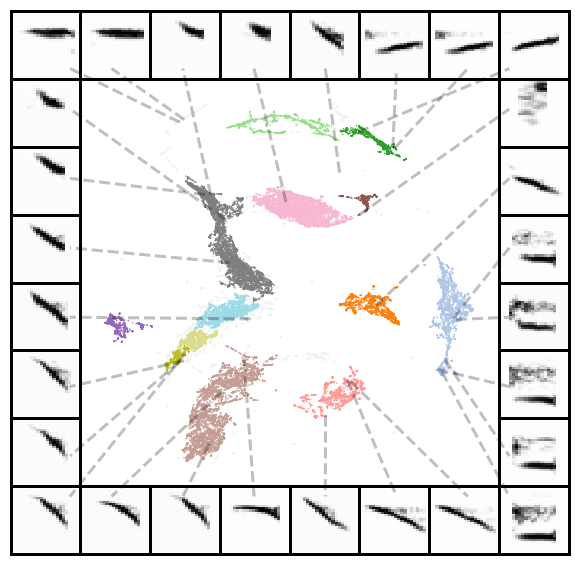

In [64]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap_cluster', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[[0.12156863 0.46666667 0.70588235]
 [0.68235294 0.78039216 0.90980392]
 [1.         0.49803922 0.05490196]
 [0.17254902 0.62745098 0.17254902]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.58039216 0.40392157 0.74117647]
 [0.54901961 0.3372549  0.29411765]
 [0.76862745 0.61176471 0.58039216]
 [0.96862745 0.71372549 0.82352941]
 [0.49803922 0.49803922 0.49803922]
 [0.7372549  0.74117647 0.13333333]
 [0.85882353 0.85882353 0.55294118]
 [0.61960784 0.85490196 0.89803922]]
[-8.02562074661255, 18.249840478897095, -7.32641191482544, 20.302898950576783]


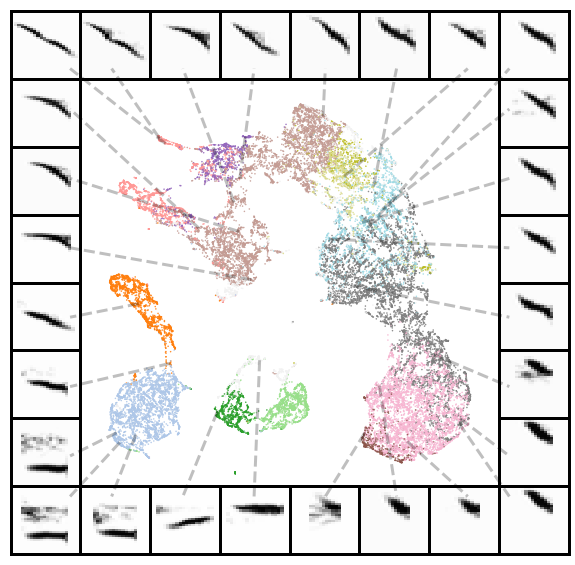

In [65]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding_features[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap-feats_cluster', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

#### plot syllable number

[4.588964113248439, 130.5992624908879, -2003.7140889352215, 6434.747424612408]


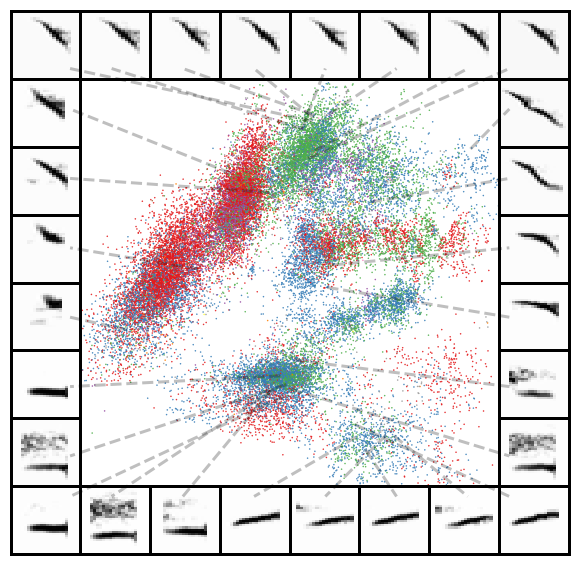

In [66]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'len_fchange_pos', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([np.exp(xmin), np.exp(xmax), ymin, ymax])

[-12.042465019226075, 17.690114860534667, -12.969955444335938, 19.087470054626465]


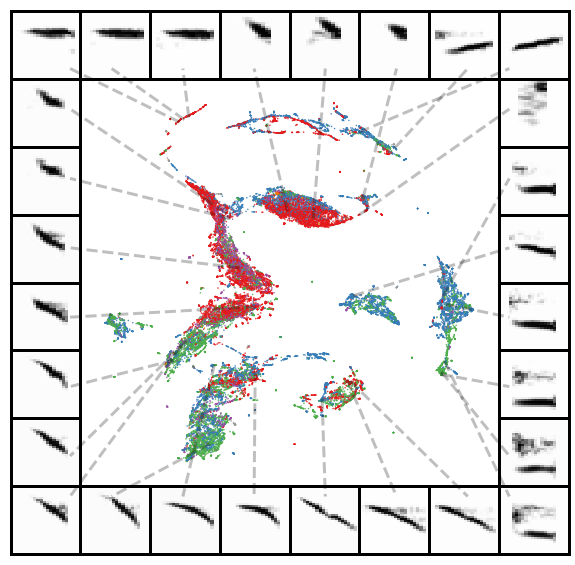

In [67]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap_pos', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[2225.1090552164155, 9623.230000317448, 2323.484628686787, 6349.476034054837]


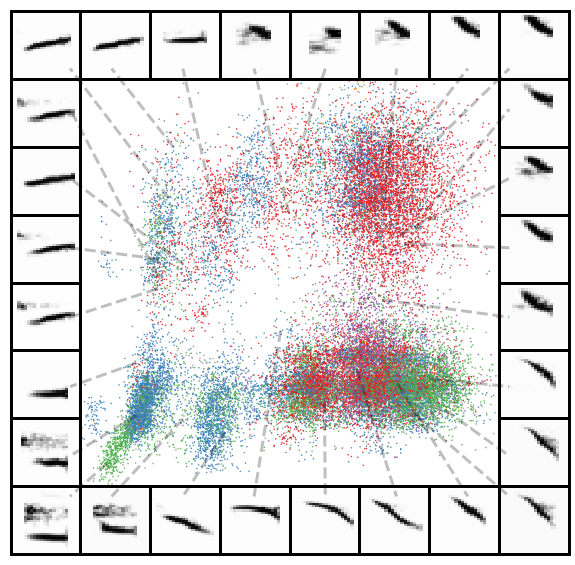

In [68]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    embedding_freq[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'fstart_fend_pos', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[0.0003269769932379942, 84295621.22820505, -7.32641191482544, 20.302898950576783]


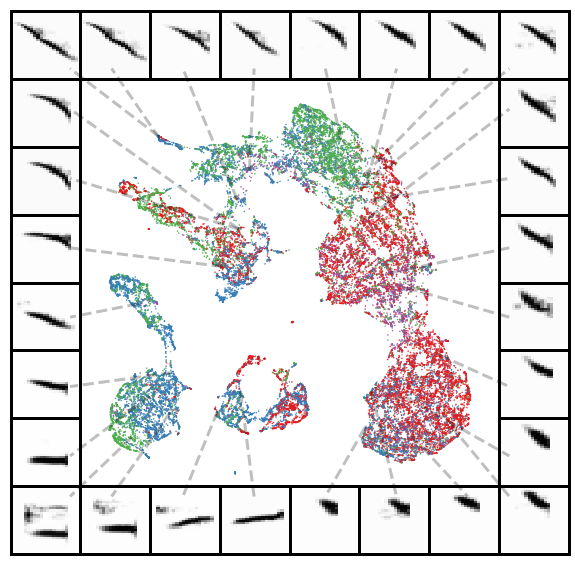

In [69]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding_features[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap-feats_pos', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([np.exp(xmin), np.exp(xmax), ymin, ymax])

#### plot features

[-12.042465019226075, 17.690114860534667, -12.969955444335938, 19.087470054626465]


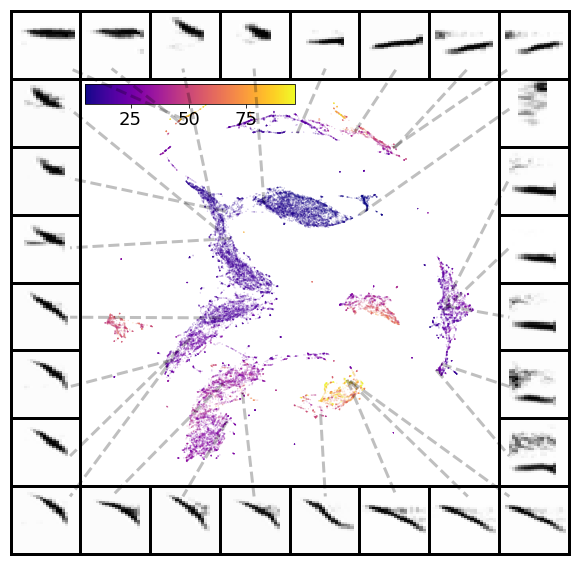

In [70]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': subset_df['syll_len'].values[:nex], #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True,
        'color_palette':'plasma',
        'categorical_labels':False,
        'tick_size':18,
        'tick_pos':'bottom',
        'cbar_orientation':"horizontal",
        'colornorm':True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap_syll_len', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[-12.042465019226075, 17.690114860534667, -12.969955444335938, 19.087470054626465]


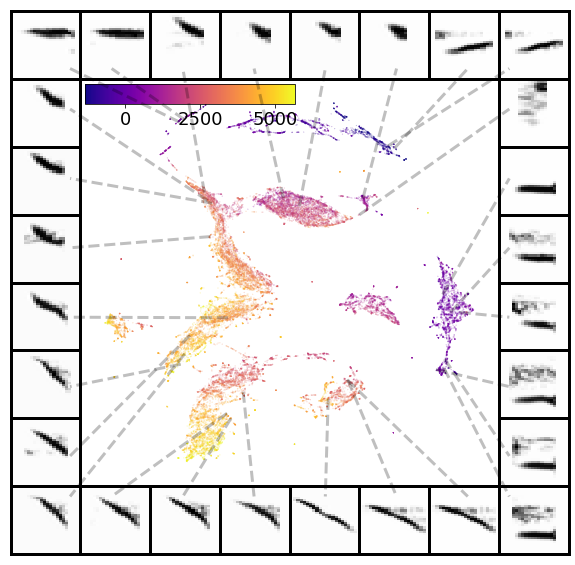

In [71]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': subset_df['f_diff'].values[:nex], #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True,
        'color_palette':'plasma',
        'categorical_labels':False,
        'tick_size':18,
        'tick_pos':'bottom',
        'cbar_orientation':"horizontal",
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap_f_diff', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[-12.042465019226075, 17.690114860534667, -12.969955444335938, 19.087470054626465]


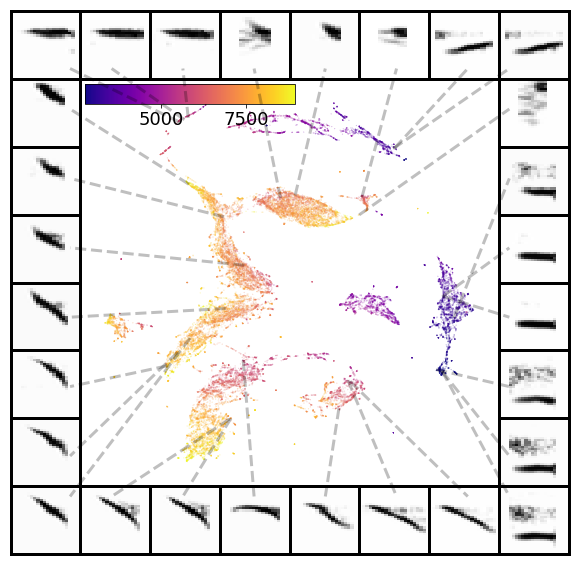

In [72]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': subset_df['peakfreq_start'].values[:nex], #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True,
        'color_palette':'plasma',
        'categorical_labels':False,
        'tick_size':18,
        'tick_pos':'bottom',
        'cbar_orientation':"horizontal",
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap_f_start', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

[-12.042465019226075, 17.690114860534667, -12.969955444335938, 19.087470054626465]


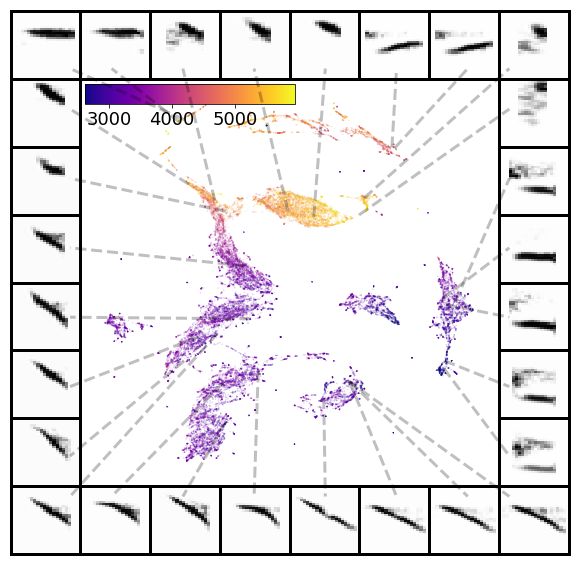

In [73]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': subset_df['peakfreq_end'].values[:nex], #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True,
        'color_palette':'plasma',
        'categorical_labels':False,
        'tick_size':18,
        'tick_pos':'bottom',
        'cbar_orientation':"horizontal",
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
if save_figs:
    figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
    ensure_dir(figs_loc)
    save_fig( figs_loc/ 'umap_f_end', dpi=300, save_jpg=True, save_png=True, save_pdf=True)
print([xmin, xmax, ymin, ymax])

#### plot spectrograms from categories

In [74]:
from avgn.visualization.spectrogram import draw_spec_set

[[0.12156863 0.46666667 0.70588235]
 [0.68235294 0.78039216 0.90980392]
 [1.         0.49803922 0.05490196]
 [0.17254902 0.62745098 0.17254902]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.58039216 0.40392157 0.74117647]
 [0.54901961 0.3372549  0.29411765]
 [0.76862745 0.61176471 0.58039216]
 [0.96862745 0.71372549 0.82352941]
 [0.49803922 0.49803922 0.49803922]
 [0.7372549  0.74117647 0.13333333]
 [0.85882353 0.85882353 0.55294118]
 [0.61960784 0.85490196 0.89803922]]


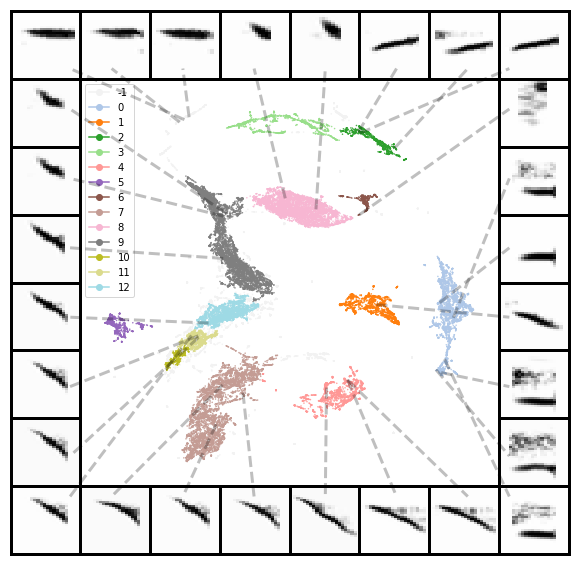

In [75]:
nex = -1
fig, axs, main_ax, [xmin, xmax, ymin, ymax] = scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);


In [76]:
unique_clusters = np.unique(clusterer.labels_)[1:]
len(unique_clusters)

13

In [77]:
lab_dict = {-1: [0.95, 0.95, 0.95, 1.0], 0: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 1: (1.0, 0.4980392156862745, 0.054901960784313725), 2: (1.0, 0.7333333333333333, 0.47058823529411764), 3: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 4: (0.596078431372549, 0.8745098039215686, 0.5411764705882353), 5: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 6: (1.0, 0.596078431372549, 0.5882352941176471), 7: (0.5803921568627451, 0.403921568627451, 0.7411764705882353), 8: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589), 9: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), 10: (0.7686274509803922, 0.611764705882353, 0.5803921568627451), 11: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), 12: (0.9686274509803922, 0.7137254901960784, 0.8235294117647058), 13: (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), 14: (0.7803921568627451, 0.7803921568627451, 0.7803921568627451), 15: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), 16: (0.8588235294117647, 0.8588235294117647, 0.5529411764705883)}

In [78]:
unique_clusters = np.unique(mixture_labels)
len(unique_clusters)

10

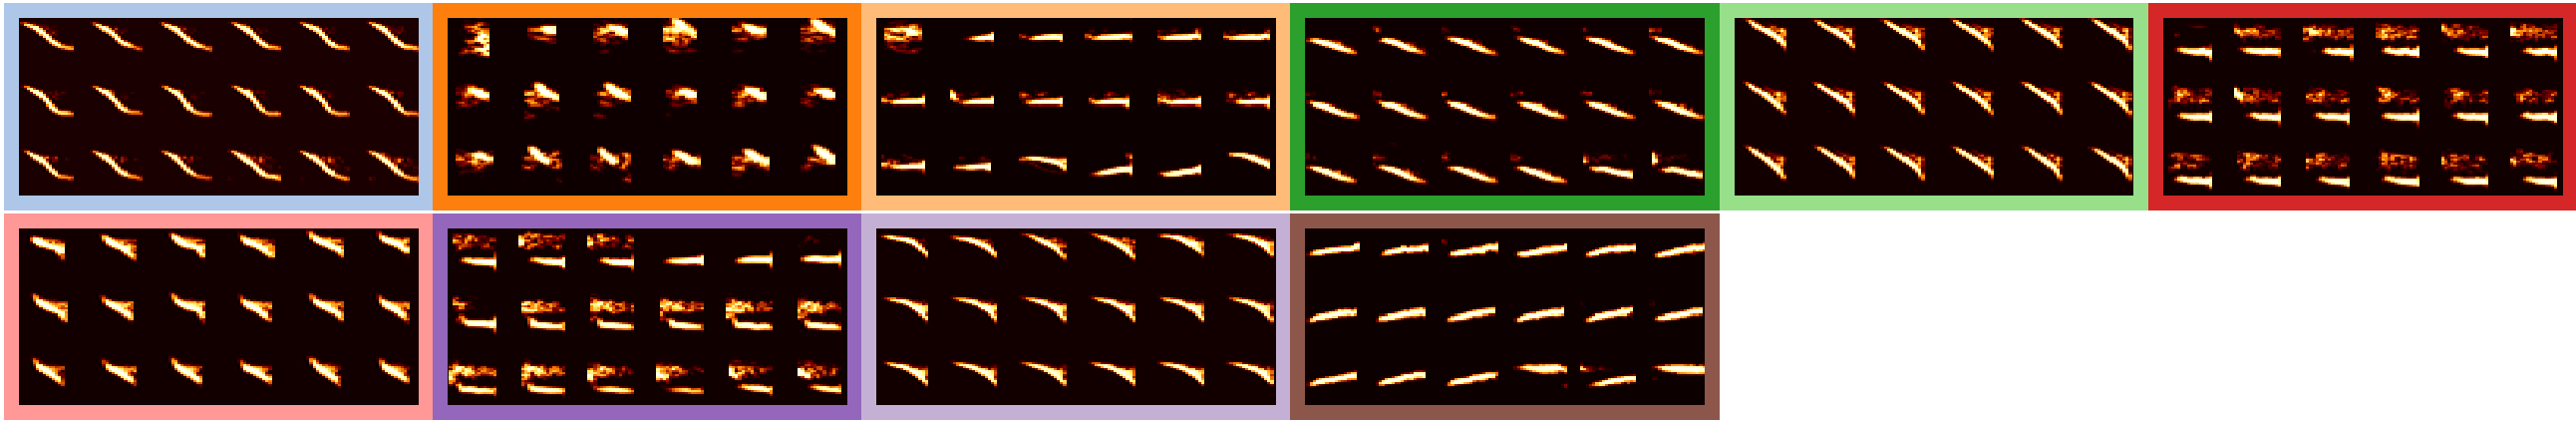

In [79]:
zm = 6
ncols=6
nrows=int(np.ceil(len(unique_clusters)/ncols))

fig, axs = plt.subplots(nrows=nrows, ncols =ncols, figsize= (ncols*zm, nrows*zm/2))
for li, label in enumerate(unique_clusters):
    ax = axs.flatten()[li]
    draw_spec_set(np.array(specs)[mixture_labels == label], zoom=1, maxrows=3, colsize=6, ax=ax, axis_off=False)
    #ax.set_title(label, fontsize=24)
    for spine in ax.spines.values():
        spine.set_edgecolor(lab_dict[label])
        spine.set_linewidth(15)
    ax.set_xticks([])
    ax.set_yticks([])
    
for li in range(li+1, ncols*nrows):
    ax = axs.flatten()[li]
    ax.axis('off')
plt.tight_layout()
plt.show();

In [80]:
subset_df[:3]

start_time  end_time  syllable  pos_in_syllable  peakfreq_start  \
0      0.1470    0.1540       0.0              0.0     6244.628906   
1      0.1485    0.1710       0.0              1.0     3273.046875   
2      0.1825    0.2095       0.0              2.0     7924.218750   

   peakfreq_end           indv  indvi         POPID      GRIDX  ...  \
0   4866.503906  PAGeneva08-57      0  Conneaut, PA  41.587287  ...   
1   3057.714844  PAGeneva08-57      0  Conneaut, PA  41.587287  ...   
2   3359.179688  PAGeneva08-57      0  Conneaut, PA  41.587287  ...   

                                               audio   rate   syll_len  \
0  [-0.0, -0.0041904511122867975, -0.004001130574...  44100   7.006803   
1  [0.0, 0.0009144610115166368, 0.003067977726459...  44100  22.517007   
2  [-0.0, -0.0002621038784754687, -0.000141924985...  44100  26.984127   

       f_start        f_end  \
0  2971.582031  3488.378906   
1  4909.570312  3014.648438   
2  7838.085938  3832.910156   

                                         spectrogram   f_diff_est  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  -516.796875   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1894.921875   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  4005.175781   

        f_diff                      UMAP  HDBSCAN  
0  1378.125000    [1.327933, 10.0425205]        8  
1   215.332031    [13.666051, 0.8677807]        0  
2  4565.039062  [-1.8427858, -7.9060984]        7  

[3 rows x 22 columns]

Text(0.5, 1.0, 'freq_diff')

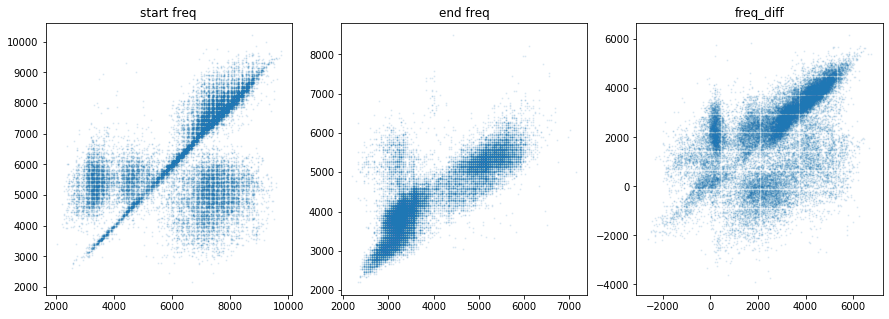

In [81]:
# compare estimated to dataset
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].scatter(subset_df.peakfreq_start, subset_df.f_start, s=1, alpha = 0.1)
axs[0].set_title('start freq')
axs[1].scatter(subset_df.peakfreq_end, subset_df.f_end, s=1, alpha = 0.1)
axs[1].set_title('end freq')
axs[2].scatter(subset_df.f_diff, subset_df.f_diff_est, s=1, alpha = 0.1)
axs[2].set_title('freq_diff')

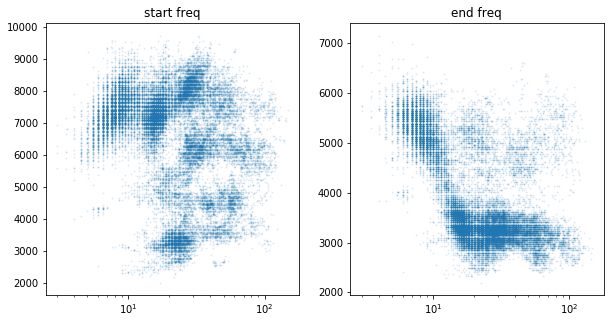

In [82]:
# compare estimated to dataset
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].scatter(subset_df.syll_len, subset_df.peakfreq_start, s=1, alpha = 0.1)
axs[0].set_title('start freq')
axs[1].scatter(subset_df.syll_len, subset_df.peakfreq_end, s=1, alpha = 0.1)
axs[1].set_title('end freq')
axs[0].set_xscale('log')
axs[1].set_xscale('log')